In [60]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [61]:
TEST_SPLIT = 0.1
# VAL_SPLIT = 0.2
BATCH_SIZE = 16
NUM_BLOCKS=7
HIDDEN_CHANNELS = 120
LEARNING_RATE = 0.001
attention = 'soft_attention'

In [62]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/yoga_proj'
!ls /content/gdrive/MyDrive/yoga_proj
# base_path = '../'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
120_h_d_LR_0.01_FEB_4_NEW_STSAE_GCN
Adaptive_avg_pooling_BLOCKSIZE_7__RC_attention_january_31_stsaegcn
Adaptive_avg_pooling_RC_attention_january_31_stsaegcn
CROSS_FOLD_STSAE_GCN_2025-02-08_B7_HC120_LR0.001_soft_attention
CROSS_FOLD_STSAE_GCN_2025-02-09_B7_HC120_LR0.001_soft_attention
data
dec16_Cross_fold
Dropout_RC_attention_january_31_stsaegcn
FEB_4_NEW_STSAE_GCN
FEB_4_no_STSAM_RES_BN_NEW_STSAE_GCN
FEB_4_with_STSAM_RES_BN_NEW_STSAE_GCN
HIGH_LR_FEB_4_NEW_STSAE_GCN
jan30_Cross_fold
january_30_CORRECTED_stsaegcn
january_31_CORRECTED_stsaegcn
LESS_POWER_MTCN_FIXED_stsaegcn
Lower_Model_Capacity_RC_attention_january_31_stsaegcn
LR_0.001_STSAE_GCN_2025-02-08_B7_HC120_soft_attention
LR_0.008_STSAE_GCN_2025-02-08_B7_HC120_soft_attention
LR_0.1_STSAE_GCN_2025-02-08_B7_HC120_soft_attention
MORE_REDUCED_4_BLOCKS_Model_Capacity_RC_attention_january_31_stsaegcn
MTCN_FI

In [63]:
import os
from datetime import datetime

# Gets label
csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')

# SAVE_PATH = os.path.join(base_path, 'STSAE_GCN')
today = datetime.today().strftime('%Y-%m-%d')
SAVE_PATH = os.path.join(
    base_path,
    f'CROSS_FOLD_STSAE_GCN_{today}_B{NUM_BLOCKS}_HC{HIDDEN_CHANNELS}_LR{LEARNING_RATE}_{attention}'
)
os.makedirs(SAVE_PATH, exist_ok=True)
print(SAVE_PATH)

pose_list = ['downward-dog','standing-forward-bend','half-way-lift',
             'mountain','chair','cobra','cockerel','extended-triangle',
             'extended-side-angle','corpse','staff','wind-relieving','fish'
            ]
NUM_CLASSES = len(pose_list)

dataset_dir = os.path.join(base_path, 'official_dataset')
assert os.path.isdir(dataset_dir), f"Directory '{dataset_dir}' does not exist."


/content/gdrive/MyDrive/yoga_proj/CROSS_FOLD_STSAE_GCN_2025-02-09_B7_HC120_LR0.001_soft_attention


In [64]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.5.1+cu124


In [65]:
meta_info_path = os.path.join(base_path, 'data')
pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')

What does each file tell?

1.) pose-index.csv -> Shows Heirarchical organization (THEN NOTHING MORE)

2.) 3DYoga90.csv -> Total Main Info(i.e. along with RGB stream){
    SequneceID: Parquet_FILE_NAME,
    URL,
    Frame Start and Frame Stop,
    Pose Name, Training Test Split
} `Difference between train and test? where to get the validation set from? How to do data augmentation?

3.) Parquet Files -> {
    Frame Number {
        33 Landmarks
    },
    row-id: FrameNumber-TYPE-Landmark_index,
    Coordinates: {x, y, z}
}

`PLEASE NOTE: The landmark coordinates are all normalized`

# Getting the data ready

In [66]:
subset_of_poses = pose_list

In [67]:
# Keep only relevant columns
def read_meta_data():
    meta_info_path = os.path.join(base_path, 'data')
    pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
    sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')
    parquet_index = sequence_index[['sequence_id', 'l3_pose', 'split']]
    return parquet_index

In [68]:
import torch
import torch.nn.functional as F
import numpy as np

def AddGaussianNoise(data, mean=0., std=0.01):
    noise = torch.randn_like(data) * std + mean
    return data + noise

def RandomRotate(data, max_angle=30):
    angle = torch.rand(1) * 2 * max_angle - max_angle  # Range: [-max_angle, max_angle] in degrees
    angle_rad = torch.deg2rad(angle)
    cos_theta = torch.cos(angle_rad)
    sin_theta = torch.sin(angle_rad)

    rotation_matrix = torch.tensor([
        [cos_theta, 0, sin_theta],
        [0, 1, 0],
        [-sin_theta, 0, cos_theta]
    ]).squeeze()

    # print(data.shape)
    # print(rotation_matrix.shape)
    # data = torch.matmul(rotation_matrix, data)
    data = torch.einsum('ij, jkl -> ikl', rotation_matrix, data)
    return data

def RandomScale(data, scale_range=(0.9, 1.1)):
    scale =  scale_range[0] + torch.rand(1) * (scale_range[1] - scale_range[0]) # 0.9 + 0.2 * percentage
    return data * scale

def RandomTranslate(data, max_translate=0.1):
    translate = torch.rand(3) * 2 * max_translate - max_translate  # Range: [-max_translate, max_translate]
    return data + translate.unsqueeze(1).unsqueeze(2)

def TimeReverse(data, p=0.5):
    if torch.rand(1) < p:
        return torch.flip(data, [1])
    else:
        return data

In [69]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class Yoga3DDataset(Dataset):
    def __init__(self, parquet_index, root_dir =  dataset_dir,subset_of_poses= subset_of_poses, sub_sampling_length = 20, transform=None, max_frames=None):
        self.parquet_index = parquet_index
        self.parquet_index = self.parquet_index[self.parquet_index['l3_pose'].isin(subset_of_poses)]
        self.root_dir = root_dir
        self.transform = transform
        self.max_frames = max_frames
        self.sub_sampling_length = sub_sampling_length
        self.pose_to_label = {pose: i for i, pose in enumerate(subset_of_poses)}
        self.use_augmentation = False

        self.cache = dict()
        self.idx_to_seq = dict()

    def __len__(self):
        return len(self.parquet_index)

    def __getitem__(self, idx):
        if idx in self.cache:
            data, label = self.cache[idx]
        else:
            fname, pose_name, _ = self.parquet_index.iloc[idx]
            label = self.pose_to_label[pose_name]
            path = os.path.join(self.root_dir, f'{fname}.parquet')

            df = pd.read_parquet(path)
            df = df.drop(columns=['frame', 'row_id', 'type','landmark_index'])

            data = self.to_tensor(df)
            data = self.sub_sample(data)
            data = data.permute(1,0,2)
            self.cache[idx] = (data, label)
            self.idx_to_seq[idx] = fname

        if self.transform and self.use_augmentation:
            data = self.transform(data.clone())

        return data, label # C, T , V

    def sub_sample(self, data):
        # data(Number_of_frames, 3, 33)
        total_frames = data.shape[0]
        indices = torch.linspace(0, total_frames -1 , self.sub_sampling_length, dtype= int)
        return data[indices]

    def to_tensor(self, df):
        # Reshape the data to (num_frames, num_landmarks, 3)  ## WHAT WHAT? this doesn't make sense remove this line you are doing (number of frames, 3 , 33)
        num_frames = len(df) // 33  # Assuming 33 landmarks per frame
        data = df.values.reshape(num_frames, 33, 3)
        return torch.FloatTensor(data).permute(0, 2, 1)

In [70]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for transform in self.transforms:
            data = transform(data)
        return data

In [71]:
class RandomApply:
    def __init__(self, transform, p=0.5):
        self.transform = transform
        self.p = p

    def __call__(self, data):
        if torch.rand(1) < self.p:
            return self.transform(data)
        else:
            return data

In [ ]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                              padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out

class CNNLSTM(nn.Module):
    def __init__(self, input_channels,hidden_size=256, num_classes=NUM_CLASSES, num_nodes=33):
        super(CNNLSTM, self).__init__()
        
        self.batch_norm = nn.BatchNorm1d(input_channels * num_nodes)
        # CNN layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True)
        )
        
        self.blk1 = ResBlock(32, 64, stride=2)
        self.blk2 = ResBlock(64, 128, stride=2)
        self.blk3 = ResBlock(128, 256, stride=2)
        self.blk4 = ResBlock(256, 512, stride=2)

        self.V_downsampled = 3
        self.lstm = nn.LSTM(512 * self.V_downsampled, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        N, C, T, V = x.size()
        
        # BATCH NORM
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(N, V * C, T)
        x = self.batch_norm(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()
        
        # CNN LAYER APPLICATION
        x = x.view(N*T, C, V)
        x = self.conv1(x)
        x = self.blk1(x)
        x = self.blk2(x)
        x = self.blk3(x)
        x = self.blk4(x)
        
        # Current shape: (N*T, 512, V_downsampled)
        _, C_out, V_down = x.size()
        x = x.view(N, T, C_out, V_down)
        
        # no interleaving (x0,y0,z0, x1,y1,z1,..) instead (x0,x1,..x32, y1, y2,...)
        x = x.view(N, T, -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        
        x = self.fc(x)
        return x
    def count_parameters(self):
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")

In [73]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, save_path = SAVE_PATH, best_path=None):
    if best_path is not None:
        chk_path = os.path.join(save_path, f'best_model.pth')
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [74]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only = False)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history


In [75]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import matplotlib.pyplot as plt

def plot_per_class_metric(precision, recall, f1, epoch=0, pose_list=None, master_save_path="SAVE_PATH"):
    """
    Plots and saves per-class metrics (Precision, Recall, F1-score) for the given epoch.

    Args:
        precision (list): Per-class precision values.
        recall (list): Per-class recall values.
        f1 (list): Per-class F1-score values.
        epoch (int): Current epoch number.
        pose_list (list): List of class names (strings) corresponding to class indices.
        master_save_path (str): Directory to save the plot.
    """
    if pose_list is None:
        pose_list = [str(i) for i in range(len(precision))]  # Default to numeric labels

    save_dir = os.path.join(master_save_path, 'per_class_metric')
    os.makedirs(save_dir, exist_ok=True)

    save_file_path = os.path.join(save_dir, f'per_class_metric_epoch_{epoch}.png')

    # Adjust x-axis positions for grouped bars
    x = range(len(pose_list))

    plt.bar([i - 0.2 for i in x], precision, width=0.2, label='Precision', align='center')
    plt.bar(x, recall, width=0.2, label='Recall', align='center')
    plt.bar([i + 0.2 for i in x], f1, width=0.2, label='F1-Score', align='center')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title(f'Per-Class Metrics - Epoch {epoch}')
    plt.xticks(x, pose_list, rotation=45, ha='right')  # Use pose_list for x-axis labels
    plt.legend()
    plt.tight_layout()  # Adjust layout to fit rotated labels
    plt.savefig(save_file_path)
    plt.show()

def per_class_metric(true, pred, epoch, pose_list=pose_list, average=None):
    """
    Computes and logs per-class metrics (Precision, Recall, F1-score).

    Args:
        true (list): Ground-truth labels.
        pred (list): Predicted labels.
        epoch (int): Current epoch number.
        pose_list (list): List of class names (strings) corresponding to class indices.
        average (str or None): Averaging method for sklearn metrics (None for per-class).
    """
    per_class_precision = precision_score(true, pred, average=average, zero_division=0)
    per_class_recall = recall_score(true, pred, average=average, zero_division=0)
    per_class_f1 = f1_score(true, pred, average=average, zero_division=0)

    print(f"Per-Class Metrics for Epoch {epoch}:")
    for i, (prec, rec, f1) in enumerate(zip(per_class_precision, per_class_recall, per_class_f1)):
        class_name = pose_list[i] if pose_list else f"Class {i}"
        print(f"{class_name}: Precision={prec:.2f}, Recall={rec:.2f}, F1-Score={f1:.2f}")

    plot_per_class_metric(per_class_precision, per_class_recall, per_class_f1, epoch, pose_list)


In [77]:
import os
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, dataset,fold, num_epochs=50, patience=18, log_interval=10, checkpoint_path=None, unfreeze_epoch=5, num_layers_unfreeze=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    # Initialize history for loss, accuracy, precision, recall, and F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    }

    # Check for checkpoint and load if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        dataset.use_augmentation = True #############
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels) in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (BATCH_SIZE * (batch_idx + 1)),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='macro')
        train_recall = recall_score(train_true, train_pred, average='macro')
        train_f1 = f1_score(train_true, train_pred, average='macro')

        per_class_metric(train_true, train_pred, epoch)

        dataset.use_augmentation = False
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_true, val_pred = [], []

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels) in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # Pass sequence lengths to model forward function
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Collect true and predicted labels for precision/recall
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (BATCH_SIZE * (batch_idx + 1)),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        # Calculate validation metrics
        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        val_precision = precision_score(val_true, val_pred, average='macro')
        val_recall = recall_score(val_true, val_pred, average='macro')
        val_f1 = f1_score(val_true, val_pred, average='macro')
        # Per-class metrics for validation
        per_class_metric(val_true, val_pred, epoch)
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f} | Val F1: {val_f1:.2f}')

        # Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(SAVE_PATH, f'best_model_fold_{fold}.pth')
            if best_model_path is not None:
                print(best_model_path)
            save_checkpoint(model, optimizer, epoch, history, SAVE_PATH, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Check for early stopping
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break

    return model, history

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names, spath=SAVE_PATH, fsave='confusion_matrix.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        spath: Directory to save the plot
        fsave: Filename for confusion matrix plot

    Returns:
        test_loss: Average test loss
        accuracy: Test accuracy
        precision: Macro precision score
        recall: Macro recall score
        f1: Macro F1 score
    """
    csave = os.path.join(spath, fsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Calculate metrics with macro averaging
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    cm = confusion_matrix(all_labels, all_predictions)
   # Create figure with adjusted size and subplot positioning
    plt.figure(figsize=(12, 10))  # Increased figure size
    plt.subplot(111, position=[0.1, 0.2, 0.8, 0.7])  # Adjust main plot position to leave room for text

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Prepare metrics text
    metrics_text = (f'Test Loss: {test_loss:.4f}\n'
                    f'Test Accuracy: {accuracy:.2f}%\n'
                    f'Precision (Macro): {precision:.4f}\n'
                    f'Recall (Macro): {recall:.4f}\n'
                    f'F1 Score (Macro): {f1:.4f}')

    # Add metrics text with adjusted position
    plt.gcf().text(0.1, 0.02, metrics_text, fontsize=12, ha='left', va='bottom')

    # Adjust layout to prevent cutting off
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Leave space at bottom for metrics 

    # Save with tight layout to include all elements
    plt.savefig(csave, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Precision (Macro): {precision:.4f}')
    print(f'Recall (Macro): {recall:.4f}')
    print(f'F1 Score (Macro): {f1:.4f}')

    return test_loss, accuracy, precision, recall, f1

In [80]:
from torch.utils.data import random_split, DataLoader

def train_val_test_split(dataset, test_split = TEST_SPLIT):
    total_size = len(dataset)
    test_size = int(test_split * total_size)
    train_size = total_size - test_size

    train_dataset, test_dataset = random_split(
        dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, test_dataset

def create_data_loaders(train_dataset, test_dataset, batch_size = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory= True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, test_loader

In [81]:

def plot_training_curves(history, fold):
    fsave=f'training_curves_fold_{fold}.png'
    tsave = os.path.join(SAVE_PATH, fsave)
    # plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axs[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss', marker='o')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy curves
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()

    # Learning rate
    axs[0, 2].plot(history['learning_rates'], label='Learning Rate', marker='o')
    axs[0, 2].set_title('Learning Rate')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend()

    # Precision
    axs[1, 0].plot(history['train_precision'], label='Train Precision', marker='o')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision', marker='o')
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()

    # Recall
    axs[1, 1].plot(history['train_recall'], label='Train Recall', marker='o')
    axs[1, 1].plot(history['val_recall'], label='Validation Recall', marker='o')
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()

    # F1 Score
    axs[1, 2].plot(history['train_f1'], label='Train F1', marker='o')
    axs[1, 2].plot(history['val_f1'], label='Validation F1', marker='o')
    axs[1, 2].set_title('F1 Score')
    axs[1, 2].legend()

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(tsave)
    plt.show()
    plt.close()


In [82]:
import numpy as np
import torch
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(pose_list, num_classes, strategy='balanced'):
    """
    Calculate class weights with proper class index alignment.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy ('balanced', 'inverse', 'effective_samples', 'sqrt_inverse')

    Returns:
        torch.Tensor: Class weights tensor aligned with class indices
    """
    # Count samples per class
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    # Initialize weights array with zeros for all possible classes
    weights = np.zeros(num_classes)

    if strategy == 'balanced':
        # Use sklearn's balanced weighting
        unique_classes = sorted(class_counts.keys())
        sklearn_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array(unique_classes),
            y=pose_list
        )
        # Map weights to correct indices
        for idx, class_label in enumerate(unique_classes):
            weights[class_label] = sklearn_weights[idx]

    elif strategy == 'inverse':
        # Inverse of sample frequency
        for class_label, count in class_counts.items():
            weights[class_label] = total_samples / (num_classes * count)

    elif strategy == 'effective_samples':
        # Effective number of samples weighting
        beta = 0.9999
        for class_label, count in class_counts.items():
            weights[class_label] = (1 - beta) / (1 - beta ** count)

    elif strategy == 'sqrt_inverse':
        # Square root of inverse frequency
        for class_label, count in class_counts.items():
            weights[class_label] = np.sqrt(total_samples / (num_classes * count))

    else:
        raise ValueError(f"Unknown weighting strategy: {strategy}")

    # Convert to tensor and normalize
    weights = torch.FloatTensor(weights)
    weights = weights / weights.sum() * len(weights)

    return weights

def create_weighted_criterion(pose_list, num_classes, strategy='balanced'):
    """
    Create a weighted CrossEntropyLoss criterion.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy for calculating class weights

    Returns:
        nn.CrossEntropyLoss: Weighted loss criterion
    """
    weights = get_class_weights(pose_list, num_classes, strategy)
    print("Class weights aligned with indices:", weights)
    if torch.cuda.is_available():
        weights = weights.cuda()
    return nn.CrossEntropyLoss(weight=weights)

def analyze_class_distribution(pose_list):
    """
    Analyze and print class distribution information.

    Args:
        pose_list: List of labels/poses in the dataset
    """
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    print("\nClass Distribution Analysis:")
    print("-" * 50)
    for class_idx, count in sorted(class_counts.items()):
        percentage = (count / total_samples) * 100
        print(f"Class {class_idx}: {count} samples ({percentage:.2f}%)")

    # Calculate imbalance metrics
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count

    print("\nImbalance Statistics:")
    print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
    print(f"Maximum class size: {max_count}")
    print(f"Minimum class size: {min_count}")
    print(f"Average class size: {total_samples/len(class_counts):.2f}")

In [83]:
from torch.utils.data import Subset

def create_data_loaders(train_idx, val_idx, dataset, batch_size=BATCH_SIZE):
    # Create subsets for this fold
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Create data loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )

    return train_loader, val_loader


In [84]:
def compute_average_history(histories):
    """
    Compute the average history across multiple folds.

    Args:
        histories (list of dict): List of history dictionaries from all folds. Each dictionary contains
                                  metrics like 'train_loss', 'val_loss', 'train_accuracy', etc., as lists.

    Returns:
        dict: Averaged history containing the same keys as the input histories.
    """
    avg_history = {}
    num_folds = len(histories)

    for key in histories[0]:  # Iterate over metric names
        # Initialize a list for each metric
        avg_history[key] = [0.0] * len(histories[0][key])  # Assume all folds have same length histories

        # Sum across all folds
        for fold_history in histories:
            for i, value in enumerate(fold_history[key]):
                avg_history[key][i] += value

        # Divide by the number of folds to compute the average
        avg_history[key] = [val / num_folds for val in avg_history[key]]

    return avg_history


In [85]:
def compute_average_history(histories):
    """
    Compute the average history across multiple folds.

    Args:
        histories (list of dict): List of history dictionaries from all folds. Each dictionary contains
                                  metrics like 'train_loss', 'val_loss', 'train_accuracy', etc., as lists.

    Returns:
        dict: Averaged history containing the same keys as the input histories.
    """
    avg_history = {}
    num_folds = len(histories)

    for key in histories[0]:  # Iterate over metric names
        # Initialize a list for each metric
        avg_history[key] = [0.0] * len(histories[0][key])  # Assume all folds have same length histories

        # Sum across all folds
        for fold_history in histories:
            for i, value in enumerate(fold_history[key]):
                avg_history[key][i] += value

        # Divide by the number of folds to compute the average
        avg_history[key] = [val / num_folds for val in avg_history[key]]

    return avg_history

In [86]:
import os
import pickle
from sklearn.model_selection import StratifiedKFold

def save_folds(meta_info_path, skf, folds):
    folds_path = os.path.join(meta_info_path, "folds.pkl")
    skf_path = os.path.join(meta_info_path, "skf.pkl")

    with open(folds_path, "wb") as f:
        pickle.dump(folds, f)

    with open(skf_path, "wb") as f:
        pickle.dump(skf, f)

def load_folds(meta_info_path):
    folds_path = os.path.join(meta_info_path, "folds.pkl")
    skf_path = os.path.join(meta_info_path, "skf.pkl")

    if os.path.exists(folds_path) and os.path.exists(skf_path):
        with open(folds_path, "rb") as f:
            folds = pickle.load(f)
        with open(skf_path, "rb") as f:
            skf = pickle.load(f)
        return skf, folds
    return None, None

In [87]:
import torch
import os
import json
import pickle

def get_weighted_loss_criterion(train_dataset, train_indices=None, meta_info_path=None, fold=None):
    """
    Get or compute weighted loss criterion, with caching support.

    Args:
        train_dataset: The training dataset
        train_indices: Optional indices for cross-validation fold
        meta_info_path: Path to save/load cached criteria
        fold: Current fold number (required if using caching)

    Returns:
        torch.nn.CrossEntropyLoss with computed weights
    """
    if meta_info_path and fold is not None:
        criterion_cache_path = os.path.join(meta_info_path, f'criterion_fold_{fold}.pkl')

        # Try to load cached criterion
        if os.path.exists(criterion_cache_path):
            try:
                with open(criterion_cache_path, 'rb') as f:
                    cached_data = pickle.load(f)

                # Verify the cached criterion matches current data
                if verify_criterion_cache(cached_data, train_indices):
                    print(f"Loading cached criterion for fold {fold}")
                    return cached_data['criterion']
                else:
                    print(f"Cached criterion for fold {fold} is invalid, recomputing...")
            except Exception as e:
                print(f"Error loading cached criterion: {e}, recomputing...")

    # Compute criterion if no cache exists or verification failed
    if train_indices is not None:
        labels = [train_dataset[i][1] for i in train_indices]
    else:
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]

    analyze_class_distribution(labels)
    criterion = create_weighted_criterion(
        labels,
        num_classes=NUM_CLASSES,
        strategy='effective_samples'
    )

    # Cache the computed criterion if path is provided
    if meta_info_path and fold is not None:
        os.makedirs(meta_info_path, exist_ok=True)
        cache_data = {
            'criterion': criterion,
            'train_indices': train_indices,
            'fold': fold
        }
        with open(criterion_cache_path, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"Cached criterion for fold {fold}")

    return criterion

def verify_criterion_cache(cached_data, current_train_indices):
    """
    Verify that cached criterion matches current training indices.

    Args:
        cached_data: Dictionary containing cached criterion and metadata
        current_train_indices: Current training indices to verify against

    Returns:
        bool: True if cache is valid, False otherwise
    """
    cached_indices = cached_data['train_indices']
    if cached_indices is None and current_train_indices is None:
        return True
    if cached_indices is None or current_train_indices is None:
        return False
    return len(cached_indices) == len(current_train_indices) and all(
        a == b for a, b in zip(sorted(cached_indices), sorted(current_train_indices))
    )

In [88]:
from sklearn.model_selection import StratifiedKFold

def main(in_channels=3, hidden_channels=HIDDEN_CHANNELS, num_classes=NUM_CLASSES, num_frames=20, LR=LEARNING_RATE, Epochs=50):
    transforms = Compose([
        RandomApply(AddGaussianNoise, p=0.5),
        RandomApply(RandomRotate, p=0.5),
        RandomApply(RandomScale, p=0.5),
        RandomApply(RandomTranslate, p=0.5),
    ])

    dataset, train_dataset, test_dataset = prepare_dataset()

    # Load precomputed folds if available
    skf, folds = load_folds(meta_info_path)

    if folds is None:
        k_folds = 5
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
        folds = list(skf.split(np.arange(len(train_dataset)), get_all_the_labels(train_dataset)))
        save_folds(meta_info_path, skf, folds)

    best_model = None
    best_val_loss = float('inf')
    best_fold = 0
    all_metrics = []

    print('Starting cross-validation...')

    for fold, (train_idx, val_idx) in enumerate(folds):
        print(f"Fold {fold + 1}/{len(folds)}")
        train_loader, val_loader = create_data_loaders(train_idx, val_idx, train_dataset)

        criterion = get_weighted_loss_criterion(
            train_dataset,
            train_idx,
            meta_info_path=meta_info_path,
            fold=fold
        )
        model = CNNLSTM(in_channels, hidden_channels, num_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        model, history = train_model(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            dataset,
            fold=fold,
            num_epochs=Epochs,
            patience=10,
            log_interval=1,
            checkpoint_path=None
        )
        plot_training_curves(history, fold)
        all_metrics.append(history)

        if history['val_loss'][-1] < best_val_loss:
            best_val_loss = history['val_loss'][-1]
            best_model = model
            best_fold = fold

    avg_history = compute_average_history(all_metrics)
    plot_training_curves(avg_history, 'average')

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    evaluate_model(best_model, test_loader, criterion, pose_list)

    model_save_path = os.path.join(SAVE_PATH, f'my_model_{best_fold}.pth')
    torch.save(best_model.state_dict(), model_save_path)


# def get_weighted_loss_criterion(train_dataset, train_indices=None):
#     """
#     Calculate class weights based on the training data only.

#     Args:
#         train_dataset: The training dataset
#         train_indices: Optional indices for cross-validation fold

#     Returns:
#         torch.nn.CrossEntropyLoss with computed weights
#     """
#     # If we're doing cross-validation, use only the fold's training data
#     if train_indices is not None:
#         labels = [train_dataset[i][1] for i in train_indices]
#     else:
#         labels = [train_dataset[i][1] for i in range(len(train_dataset))]

#     analyze_class_distribution(labels)

#     # Create weighted loss criterion
#     criterion = create_weighted_criterion(
#         labels,
#         num_classes=NUM_CLASSES,
#         strategy='effective_samples'
#     )

#     return criterion
def prepare_dataset():
    dataset = Yoga3DDataset(read_meta_data()) #removed transforms for now
    train_dataset, test_dataset = train_val_test_split(dataset)
    # train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)
    return dataset,train_dataset,test_dataset

def get_all_the_labels(dataset):
    return [label for _, label in dataset]

In [89]:
# from sklearn.model_selection import StratifiedKFold

# def main(in_channels = 3, hidden_channels= HIDDEN_CHANNELS, num_classes= NUM_CLASSES, num_frames= 20, LR = LEARNING_RATE, Epochs =50):
#     transforms = Compose([
#         RandomApply(AddGaussianNoise, p=0.5),
#         RandomApply(RandomRotate, p=0.5),
#         RandomApply(RandomScale, p=0.5),
#         RandomApply(RandomTranslate, p=0.5),
#         # TimeReverse(p=0.5)
#         # Normalize,
#     ])

#     dataset, train_dataset, test_dataset = prepare_dataset(transforms)

#     # checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
#     k_folds = 5
#     skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

#     folds = list(skf.split(np.arange(len(train_dataset)), get_all_the_labels(train_dataset)))

#     best_model = None
#     best_val_loss = float('inf')
#     best_fold = 0
#     all_metrics = []
#     loss_weights = None
#     print('starting')
#     for fold, (train_idx, val_idx) in enumerate(folds):
#         print(f"Fold {fold + 1}/{k_folds}")
#         train_loader, val_loader = create_data_loaders(train_idx, val_idx, train_dataset)

#         criterion = get_weighted_loss_criterion(dataset) # Cross Entropy Loss
#         model = STSAE_GCN(in_channels, hidden_channels, num_classes, num_frames)
#         optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#         model, history = train_model(
#             model,
#             train_loader,
#             val_loader,
#             criterion,
#             optimizer,
#             dataset,
#             fold= fold,
#             num_epochs= Epochs,
#             patience=20,
#             log_interval=1,
#             checkpoint_path=None
#         )
#         plot_training_curves(history, fold)
#         all_metrics.append(history)

#         print(history['val_loss'][-1])
#         print(type(history['val_loss'][-1]))
#         if history['val_loss'][-1] < best_val_loss:
#             best_val_loss = history['val_loss'][-1]
#             best_model = model
#             best_fold = fold

#     avg_history = compute_average_history(all_metrics)
#     plot_training_curves(avg_history, 'average')  # Plot the average history

#     test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)
#     evaluate_model(best_model, test_loader, criterion, pose_list)

#     model_save_path = os.path.join(SAVE_PATH, f'my_model_{best_fold}.pth')
#     torch.save(best_model.state_dict(), model_save_path)

# def get_weighted_loss_criterion(dataset):
#     all_labels = [dataset[i][1] for i in range(len(dataset))]
#     analyze_class_distribution(all_labels)

#     # Create weighted loss criterion
#     criterion = create_weighted_criterion(
#         all_labels,
#         num_classes= NUM_CLASSES,
#         strategy='effective_samples'  # Try different strategies
#     )

#     return criterion

# def prepare_dataset(transforms):
#     dataset = Yoga3DDataset(read_meta_data(), transform=transforms)
#     train_dataset, test_dataset = train_val_test_split(dataset)
#     # train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)
#     return dataset,train_dataset,test_dataset

# def get_all_the_labels(dataset):
#     return [label for _, label in dataset]

Starting cross-validation...
Fold 1/5

Class Distribution Analysis:
--------------------------------------------------
Class 0: 184 samples (14.06%)
Class 1: 162 samples (12.38%)
Class 2: 149 samples (11.38%)
Class 3: 115 samples (8.79%)
Class 4: 94 samples (7.18%)
Class 5: 92 samples (7.03%)
Class 6: 89 samples (6.80%)
Class 7: 79 samples (6.04%)
Class 8: 73 samples (5.58%)
Class 9: 70 samples (5.35%)
Class 10: 65 samples (4.97%)
Class 11: 69 samples (5.27%)
Class 12: 68 samples (5.19%)

Imbalance Statistics:
Imbalance Ratio (max/min): 2.83
Maximum class size: 184
Minimum class size: 65
Average class size: 100.69
Class weights aligned with indices: tensor([0.4896, 0.5555, 0.6036, 0.7807, 0.9541, 0.9747, 1.0074, 1.1344, 1.2273,
        1.2797, 1.3778, 1.2981, 1.3172])
Cached criterion for fold 0
Using device: cuda

Epoch 1/50
Current Learning Rate: 0.001


Training: 100%|██████████| 82/82 [00:06<00:00, 12.73it/s, loss=1.45, accuracy=60.9]


Per-Class Metrics for Epoch 0:
downward-dog: Precision=0.66, Recall=0.69, F1-Score=0.68
standing-forward-bend: Precision=0.72, Recall=0.48, F1-Score=0.58
half-way-lift: Precision=0.71, Recall=0.84, F1-Score=0.77
mountain: Precision=0.63, Recall=0.66, F1-Score=0.64
chair: Precision=0.48, Recall=0.50, F1-Score=0.49
cobra: Precision=0.68, Recall=0.68, F1-Score=0.68
cockerel: Precision=0.70, Recall=0.65, F1-Score=0.67
extended-triangle: Precision=0.56, Recall=0.52, F1-Score=0.54
extended-side-angle: Precision=0.45, Recall=0.49, F1-Score=0.47
corpse: Precision=0.28, Recall=0.34, F1-Score=0.31
staff: Precision=0.59, Recall=0.74, F1-Score=0.65
wind-relieving: Precision=0.81, Recall=0.68, F1-Score=0.74
fish: Precision=0.45, Recall=0.40, F1-Score=0.42


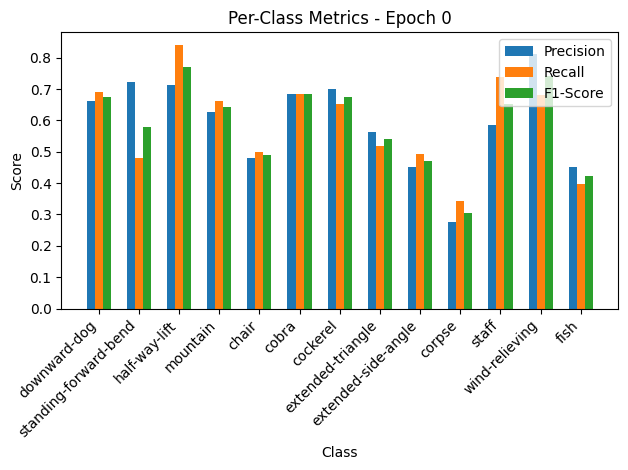

Validation:  38%|███▊      | 8/21 [01:13<03:56, 18.23s/it, loss=0.911, accuracy=60.9]

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm
import csv

def find_sus(model, test_loader, criterion, class_names, spath=SAVE_PATH, fsave='confusion_matrix_all.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    sussave = os.path.join(spath, 'sus.csv')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    misclassified_data = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Check if the sample is misclassified
            misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            for misclassified_idx in misclassified_indices:
                global_idx = batch_idx * inputs.size(0) + misclassified_idx.item()
                sequence_id = test_loader.dataset.idx_to_seq[global_idx]
                correct_label = class_names[labels[misclassified_idx].item()]
                prediction = class_names[predicted[misclassified_idx].item()]
                misclassified_data.append([sequence_id, correct_label, prediction])

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=pose_list, yticklabels=pose_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    # Save misclassified data to CSV
    with open(sussave, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['sequence_id', 'correct_label', 'prediction'])
        writer.writerows(misclassified_data)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [ ]:
dataset = Yoga3DDataset(read_meta_data())
label_to_pose = {v:k for k,v in dataset.pose_to_label.items()}

# model = STSAE_GCN(3, HIDDEN_CHANNELS, NUM_CLASSES, 20, NUM_BLOCKS)
in_channels = 3
hidden_channels = HIDDEN_CHANNELS
num_classes = NUM_CLASSES
model = CNNLSTM(in_channels, hidden_channels, num_classes)
# criterion = nn.CrossEntropyLoss()
all_labels = [dataset[i][1] for i in range(len(dataset))]
criterion = create_weighted_criterion(
        all_labels,
        num_classes= NUM_CLASSES,
        strategy='inverse'  # Try different strategies
    )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
# Plot the training curves
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
# plot_training_curves(history)
find_sus(model, loader, criterion, label_to_pose)